In [1]:
import sys
sys.path.append('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/')
import yaml
import torch
# from models_.lvmogp_svi import LVMOGP_SVI
from modules.prepare_and_train_model_encoderlatent import LVMOGP_SVI
from models_.gaussian_likelihood import GaussianLikelihood
from modules.prepare_data import *
from util_functions import *
from tqdm import trange

# Load in model

In [2]:
# Specify model and likelihood

with open('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/configs/spatiotemp_lvmogp_encoderlatent_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

my_model = LVMOGP_SVI(
    n_outputs = config['n_outputs'],
    n_input = config['n_input_train'],
    input_dim = config['input_dim'],
    latent_dim = config['latent_dim'],
    n_inducing_input = config['n_inducing_input'],
    n_inducing_latent = config['n_inducing_latent'],
    learn_inducing_locations_latent = config['learn_inducing_locations_latent'],
    learn_inducing_locations_input = config['learn_inducing_locations_input'],
    latent_kernel_type = config['latent_kernel_type'],
    input_kernel_type = config['input_kernel_type']
    )

my_likelihood = GaussianLikelihood()

In [3]:
# Load trained model and likelihood

model_state_dict = torch.load(config['model_path'])
my_model.load_state_dict(model_state_dict)

likelihood_state_dict = torch.load(config['likelihood_path'])
my_likelihood.load_state_dict(likelihood_state_dict)

<All keys matched successfully>

# Load in dataset

In [4]:
if config['dataset_type'] == 'spatio_temporal_data':
        data_inputs, data_Y_squeezed, ls_of_ls_train_input, ls_of_ls_test_input, lon_lat_tensor, train_sample_idx_ls, test_sample_idx_ls = prepare_spatio_temp_data(config)

n_data4visual = 500
inputs_total4visual = Tensor(np.linspace(config['min_input_bound'], config['max_input_bound'], n_data4visual))

# Testing via mean of latent dist

In [5]:
all_pred_mean_, all_pred_var_ = pred4all_outputs_inputs(my_model=my_model,
                                                        my_likelihood=my_likelihood,
                                                        data_inputs=data_inputs,
                                                        config=config,
                                                        approach='mean',
                                                        latent_type='NNEncoder',
                                                        latent_info=lon_lat_tensor)


In [6]:
all_pred_mean4visual_, all_pred_var4visual_ = pred4all_outputs_inputs(my_model=my_model,
                                                        my_likelihood=my_likelihood,
                                                        data_inputs=inputs_total4visual,
                                                        config=config,
                                                        approach='mean',
                                                        latent_type='NNEncoder',
                                                        latent_info=lon_lat_tensor,
                                                        not4visual=False,
                                                        n_data4visual=n_data4visual)


## Train/Test data RMSE

In [7]:
train_data_predict_ = all_pred_mean_[train_sample_idx_ls]
train_rmse_ = (train_data_predict_ - data_Y_squeezed[train_sample_idx_ls]).square().mean().sqrt()
print('Global Train RMSE via mean', train_rmse_)

w_test_data_predict_ = all_pred_mean_[test_sample_idx_ls]
test_rmse_ = (w_test_data_predict_ - data_Y_squeezed[test_sample_idx_ls]).square().mean().sqrt()
print('Global Test RMSE via mean', test_rmse_)

Global Train RMSE via mean tensor(0.4901)
Global Test RMSE via mean tensor(0.5075)


## Train/Test data NLL

In [8]:
train_nll_ = neg_log_likelihood(Target=data_Y_squeezed[train_sample_idx_ls], GaussianMean=all_pred_mean_[train_sample_idx_ls], GaussianVar=all_pred_var_[train_sample_idx_ls])
test_nll_ = neg_log_likelihood(Target=data_Y_squeezed[test_sample_idx_ls], GaussianMean=all_pred_mean_[test_sample_idx_ls], GaussianVar=all_pred_var_[test_sample_idx_ls])

print('Global Train negative log likelihood via mean:', train_nll_)
print('Global Test negative log likelihood via mean:', test_nll_)

Global Train negative log likelihood via mean: tensor(0.5362)
Global Test negative log likelihood via mean: tensor(0.5738)


## Loop over all function index

In [9]:
train_rmse_list_ = [] # list of tensors
test_rmse_list_ = []
train_nll_list_ = []
test_nll_list_ = []
for output_index in range(config['n_outputs']):
    _, _, _, _, _, _, performance_dirct = evaluate_on_single_output(
                                                        function_index = output_index,
                                                        data_inputs = data_inputs,
                                                        data_Y_squeezed = data_Y_squeezed,
                                                        ls_of_ls_train_input = ls_of_ls_train_input,
                                                        ls_of_ls_test_input = ls_of_ls_test_input,
                                                        train_sample_idx_ls = train_sample_idx_ls,
                                                        test_sample_idx_ls = test_sample_idx_ls,
                                                        all_pred_mean = all_pred_mean_,
                                                        all_pred_var = all_pred_var_,
                                                        n_data4visual = n_data4visual,
                                                        all_pred_mean4visual = all_pred_mean4visual_,
                                                        all_pred_var4visual = all_pred_var4visual_                                                        
                                                        )
    train_rmse_list_.append(performance_dirct['train_rmse'])
    test_rmse_list_.append(performance_dirct['test_rmse'])
    train_nll_list_.append(performance_dirct['train_nll'])
    test_nll_list_.append(performance_dirct['test_nll'])

In [10]:
def find_median_index(lst):
    sorted_lst = sorted(lst)
    n = len(lst)
    
    if n % 2 != 0:
        median = sorted_lst[n // 2]
        return lst.index(median)
    else:
        mid1 = sorted_lst[n // 2 - 1]
        mid2 = sorted_lst[n // 2]
        
        return lst.index(mid1)  # lst.index(mid2)

In [11]:
print('The output index with WORSE test rmse performance: ', test_rmse_list_.index(max(test_rmse_list_)))
print('The output index with WORSE test nll performance: ', test_nll_list_.index(max(test_nll_list_)))
print('------' * 10)
print('The output index with MIDDLE test rmse performance:', find_median_index(test_rmse_list_))
print('The output index with MIDDLE test nll performance:', find_median_index(test_nll_list_))
print('------' * 10)
print('The output index with BEST test rmse performance: ', test_rmse_list_.index(min(test_rmse_list_)))
print('The output index with BEST test nll performance: ', test_nll_list_.index(min(test_nll_list_)))

The output index with WORSE test rmse performance:  970
The output index with WORSE test nll performance:  969
------------------------------------------------------------
The output index with MIDDLE test rmse performance: 95
The output index with MIDDLE test nll performance: 301
------------------------------------------------------------
The output index with BEST test rmse performance:  397
The output index with BEST test nll performance:  460


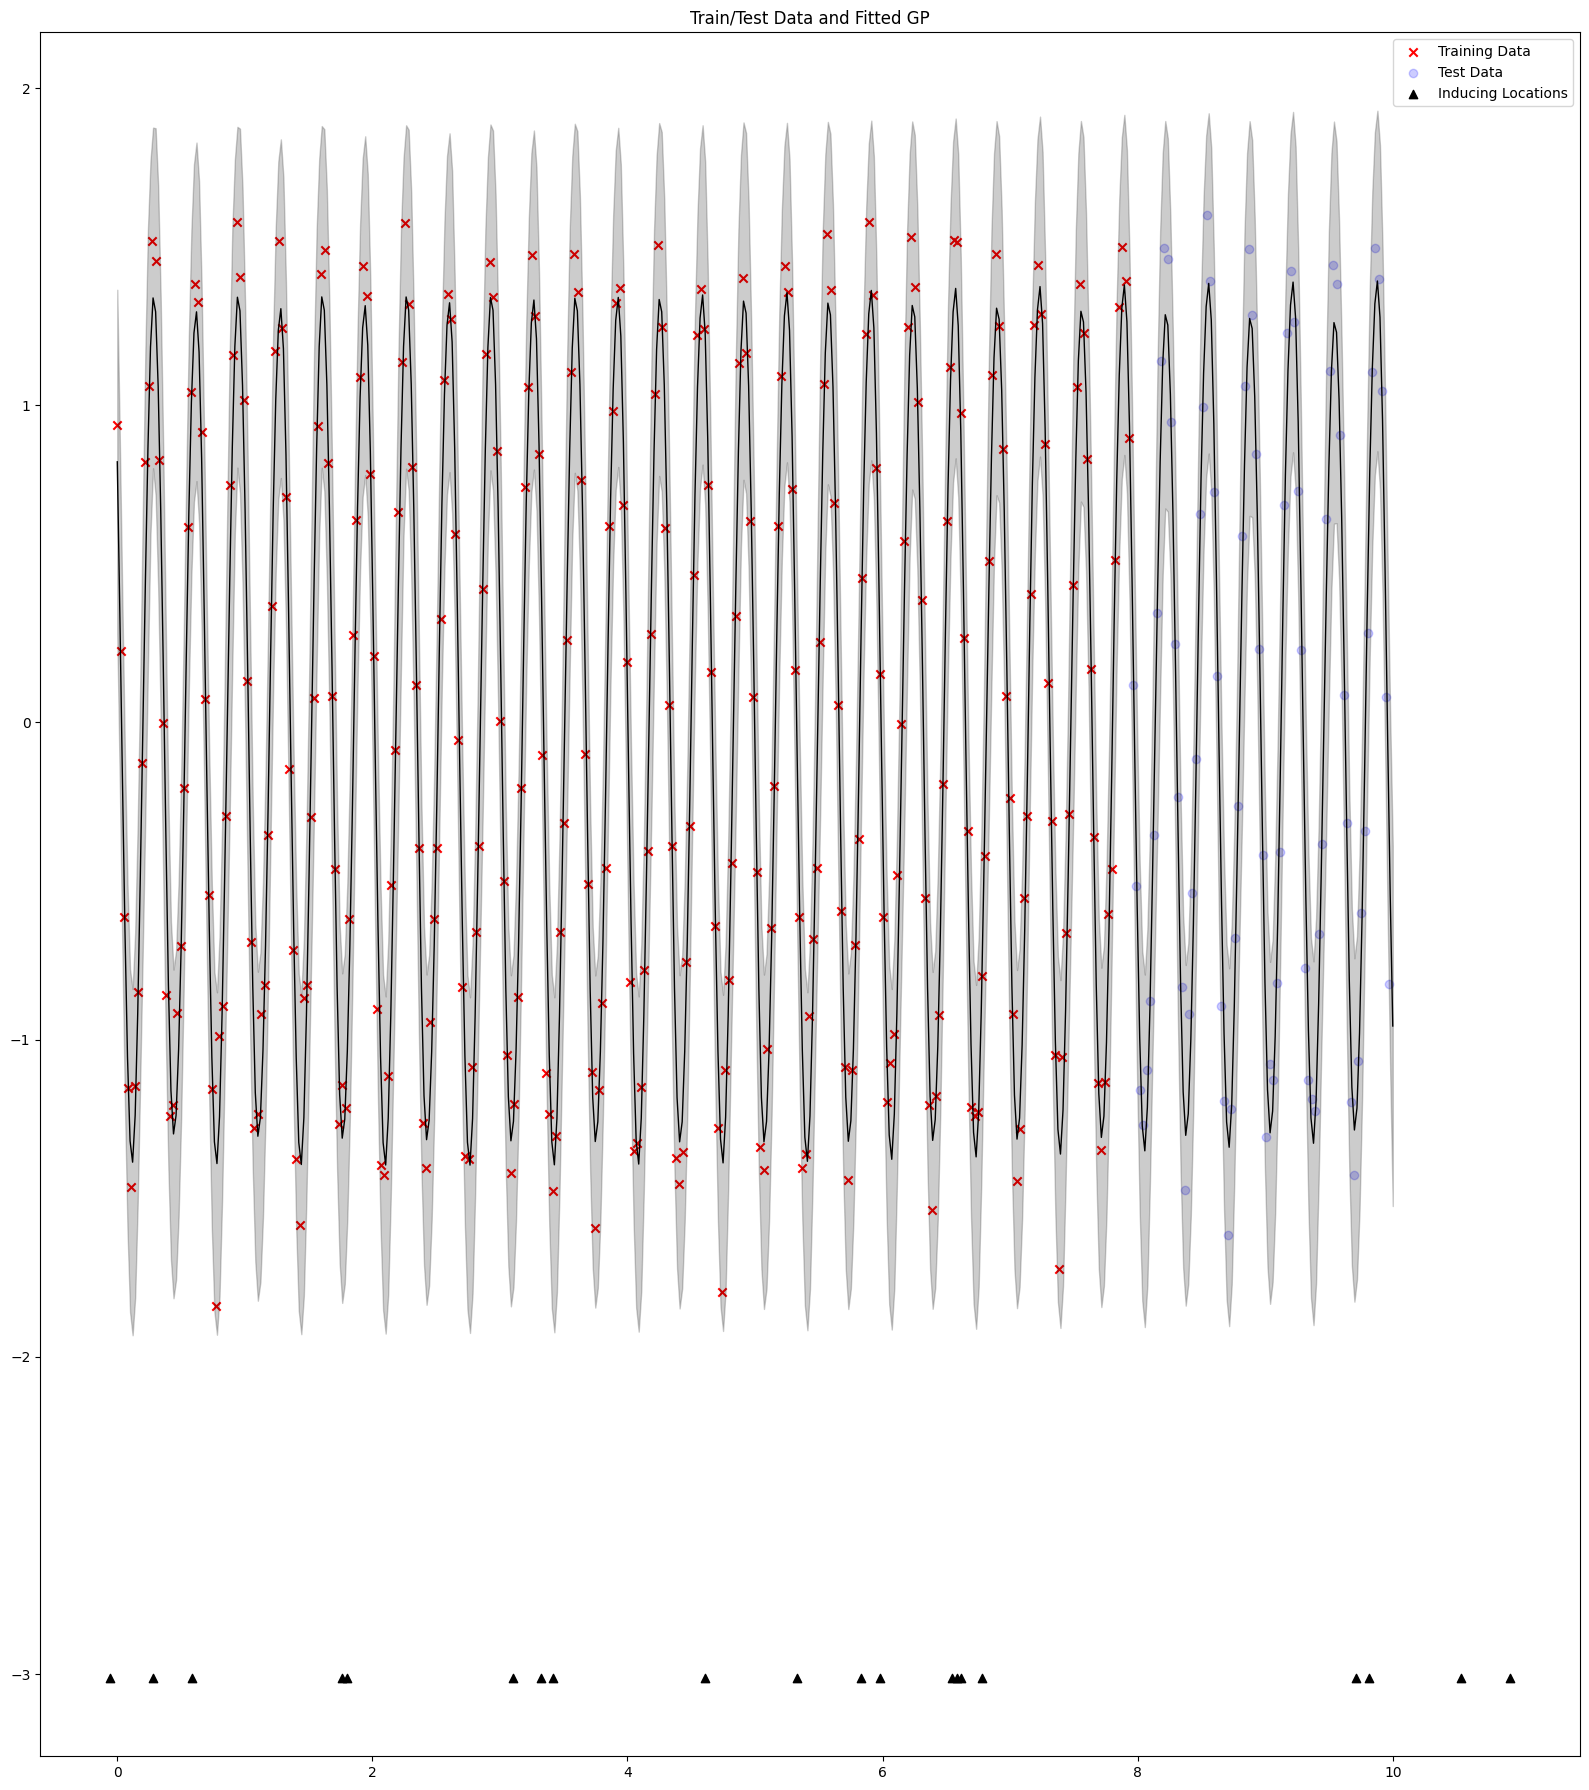

In [12]:
function_index = 252
w_train_input, w_train_target, w_test_input, w_test_target, w_gp_pred_mean, w_gp_pred_std, performance_dirct = evaluate_on_single_output(
                                                        function_index = function_index,
                                                        data_inputs = data_inputs,
                                                        data_Y_squeezed = data_Y_squeezed, 
                                                        ls_of_ls_train_input = ls_of_ls_train_input,
                                                        ls_of_ls_test_input = ls_of_ls_test_input,
                                                        train_sample_idx_ls = train_sample_idx_ls,
                                                        test_sample_idx_ls = test_sample_idx_ls,
                                                        all_pred_mean = all_pred_mean_,
                                                        all_pred_var = all_pred_var_,
                                                        n_data4visual = n_data4visual,
                                                        all_pred_mean4visual = all_pred_mean4visual_,
                                                        all_pred_var4visual = all_pred_var4visual_                                                        
)
picture_save_path = f'/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/experi_results/func_id_{function_index}_numofoutput_{config["n_outputs"]}.png'
plot_traindata_testdata_fittedgp(train_X=w_train_input, train_Y=w_train_target, test_X=w_test_input, test_Y=w_test_target, gp_X=inputs_total4visual, gp_pred_mean=w_gp_pred_mean, gp_pred_std=w_gp_pred_std, inducing_points_X=my_model.variational_strategy.inducing_points_input.data, n_inducing_C=config['n_inducing_input'], picture_save_path=picture_save_path) # NOTE: input is C not X